In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import lsq_linear   
from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment_utils as expt
import utils.misc_utils as mutil

reload(polc)
reload(expt)
reload(mutil);

## Simulation Parameters

In [2]:
# simulation lengths
T_horizon = None # time horizon (to be set later)
T_horizon_list = 2000*np.arange(1,11)
N_runs    = 50 # number of simulations

# noise and arrival rates
arrival_rate   = 5  # lambda
noise_variance = 5 # sigma^2

# algorithm parameters
beta  = 8*noise_variance # exploration tuner (beta > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (T^{1/3}) (to be set later)
delta = None # exploration tuner (T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

# topology
N_nodes          = 5
source_node      = 0
destination_node = 4
edges_list       = [[0,1], [0,2], [0,3], [1,4], [2,4], [3,4]]
node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

# edge properties
edge_capacities = np.array([1, 2, 3, 5, 5, 5])
true_edge_costs = np.array([1, 2, 3, 6, 4, 2])

# pack parameters
simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_node, destination_node, 
                 noise_variance, 
                 arrival_rate, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

## DPOP Policy

In [3]:
np.random.seed(13)

tran_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
tran_non_null_cost_till_T_dpop = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_dpop = np.zeros(T_horizon_list.shape)
for ii in trange(T_horizon_list.shape[0]):
    T_horizon_value             = T_horizon_list[ii]
    simulation_params.T_horizon = T_horizon_value
    simulation_params.nu        = T_horizon_value**(1/3)   
    simulation_params.delta     = T_horizon_value**(-2*noise_variance/(beta-2*noise_variance))

    queueing_network = expt.run_horizon_experiment(simulation_params, 'dpop')
    tran_cost_till_tt, tran_non_null_cost_till_tt, _, _, backlog_cost_at_tt, _ = expt.calculate_costs(queueing_network)
    
    tran_cost_till_T_dpop[ii] = tran_cost_till_tt[-1]
    tran_non_null_cost_till_T_dpop[ii] = tran_non_null_cost_till_tt[-1]
    backlog_cost_at_T_dpop[ii] = backlog_cost_at_tt[-1]

dpop_costs = tran_cost_till_T_dpop + backlog_cost_at_T_dpop
dpop_non_null_costs = tran_non_null_cost_till_T_dpop + backlog_cost_at_T_dpop

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [11:22<00:00, 68.26s/it] 


In [4]:
print('True costs = ' + str(true_edge_costs))
print('Observed cost mean = ' + str(queueing_network.edge_cost_means[0,:]))

True costs = [1 2 3 6 4 2]
Observed cost mean = [0.99825206 2.00031042 2.99445713 6.03057632 3.98452246 2.02045568]


## Oracle DPP Policy

In [5]:
np.random.seed(13)

tran_cost_till_T_oracle = np.zeros(T_horizon_list.shape)
tran_non_null_cost_till_T_oracle = np.zeros(T_horizon_list.shape)
backlog_cost_at_T_oracle = np.zeros(T_horizon_list.shape)
for ii in trange(T_horizon_list.shape[0]):
    T_horizon_value             = T_horizon_list[ii]
    simulation_params.T_horizon = T_horizon_value
    simulation_params.nu        = T_horizon_value**(1/3)   
    simulation_params.delta     = T_horizon_value**(-2*noise_variance/(beta-2*noise_variance))

    queueing_network = expt.run_horizon_experiment(simulation_params, 'oracle')
    tran_cost_till_tt, tran_non_null_cost_till_tt, _, _, backlog_cost_at_tt, _ = expt.calculate_costs(queueing_network)

    tran_cost_till_T_oracle[ii] = tran_cost_till_tt[-1]
    tran_non_null_cost_till_T_oracle[ii] = tran_non_null_cost_till_tt[-1]
    backlog_cost_at_T_oracle[ii] = backlog_cost_at_tt[-1]

oracle_costs = tran_cost_till_T_oracle + backlog_cost_at_T_oracle
oracle_non_null_costs = tran_non_null_cost_till_T_oracle + backlog_cost_at_T_oracle

100%|██████████| 10/10 [11:18<00:00, 67.85s/it] 


In [1]:
np.random()

NameError: name 'np' is not defined

## Static Policy

In [6]:
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)

total_stat_cost_per_time = stat_edge_rates@true_edge_costs
stat_costs = T_horizon_list*total_stat_cost_per_time

## Cost and Regret

In [7]:
# plt.plot(T_horizon_list, dpop_costs, label = 'dpop')
# plt.plot(T_horizon_list, oracle_costs, label = 'oracle')
# plt.plot(T_horizon_list, stat_costs, label = 'stat')
# plt.legend()
# plt.show()

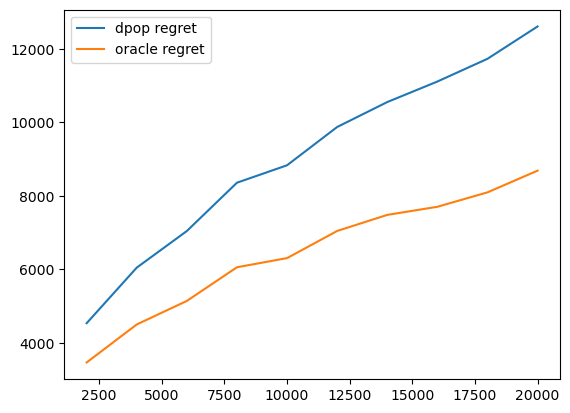

In [8]:
plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
plt.plot(T_horizon_list, oracle_costs - stat_costs, label = 'oracle regret')
plt.legend()
plt.savefig('foo1.png', bbox_inches='tight')
plt.show()

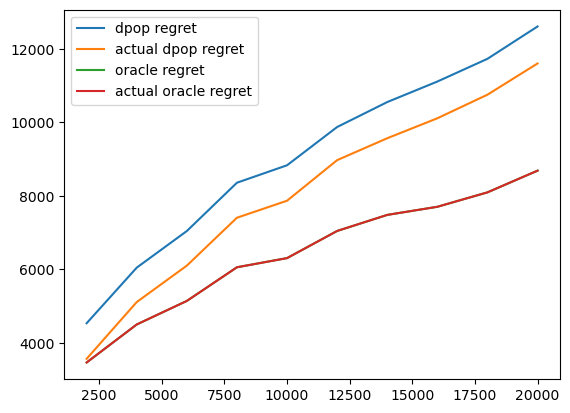

In [9]:
plt.plot(T_horizon_list, dpop_costs - stat_costs, label = 'dpop regret')
plt.plot(T_horizon_list, dpop_non_null_costs - stat_costs, label = 'actual dpop regret')

plt.plot(T_horizon_list, oracle_costs - stat_costs, label = 'oracle regret')
plt.plot(T_horizon_list, oracle_non_null_costs - stat_costs, label = 'actual oracle regret')

plt.legend()
plt.show()

[9.34331176e+00 1.61203382e-16 1.00000000e+02]


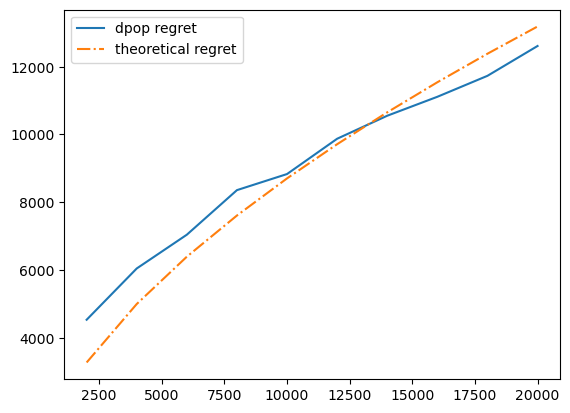

In [10]:
dpop_regret = dpop_costs - stat_costs

X = np.ones([T_horizon_list.shape[0], 3])
X[:,0] = (T_horizon_list**(1/2))*np.log(T_horizon_list)
X[:,1] = T_horizon_list**(2/3) 
# X[:,1] = T_horizon_list**(1/2) 

regret_fit_dpop = lsq_linear(X, dpop_regret, bounds=(0, 100))
theoretical_dpop_regret = X@regret_fit_dpop.x
print(regret_fit_dpop.x)

plt.plot(T_horizon_list, dpop_regret, '-', label = 'dpop regret')
plt.plot(T_horizon_list, theoretical_dpop_regret, '-.', label = 'theoretical regret')
plt.legend()
plt.show()